Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Training (Dataset B) ---
Epoch 1/20
98/98 - 2s - 22ms/step - accuracy: 0.2540 - loss: 1.8410
Epoch 2/20
98/98 - 0s - 2ms/step - accuracy: 0.3120 - loss: 1.6530
Epoch 3/20
98/98 - 0s - 3ms/step - accuracy: 0.3382 - loss: 1.5771
Epoch 4/20
98/98 - 0s - 3ms/step - accuracy: 0.3587 - loss: 1.5345
Epoch 5/20
98/98 - 0s - 3ms/step - accuracy: 0.3655 - loss: 1.5077
Epoch 6/20
98/98 - 0s - 3ms/step - accuracy: 0.3746 - loss: 1.4872
Epoch 7/20
98/98 - 0s - 3ms/step - accuracy: 0.3798 - loss: 1.4702
Epoch 8/20
98/98 - 0s - 4ms/step - accuracy: 0.3883 - loss: 1.4562
Epoch 9/20
98/98 - 1s - 6ms/step - accuracy: 0.3941 - loss: 1.4410
Epoch 10/20
98/98 - 1s - 7ms/step - accuracy: 0.3978 - loss: 1.4290
Epoch 11/20
98/98 - 0s - 2ms/step - accuracy: 0.4005 - loss: 1.4178
Epoch 12/20
98/98 - 0s - 2ms/step - accuracy: 0.4052 - loss: 1.4059
Epoch 13/20
98/98 - 0s - 3ms/step 

✅ Model saved to /content/drive/MyDrive/trained_sca_model.h5


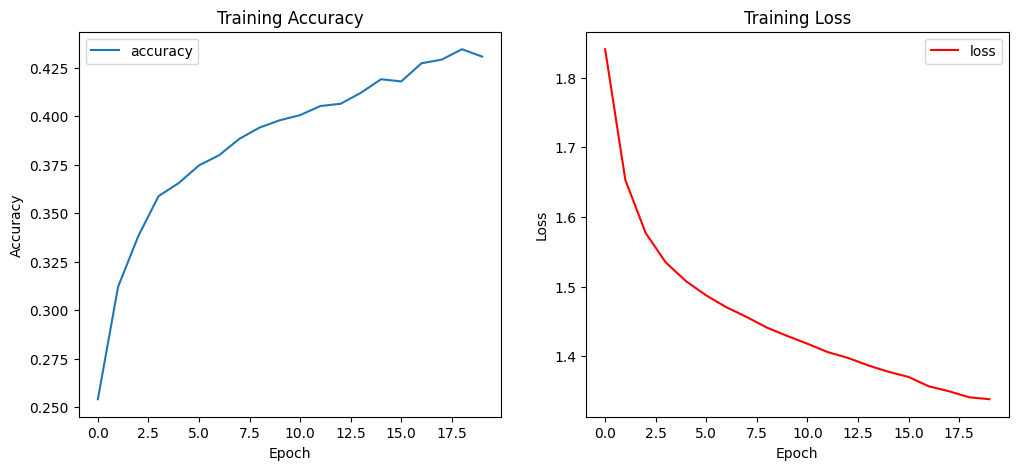


--- Attack (Dataset A) ---


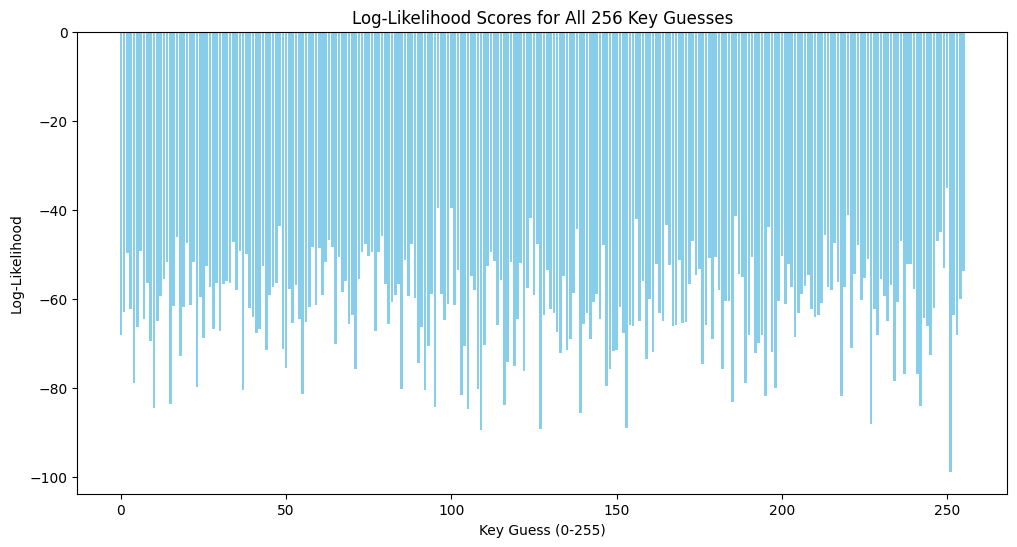

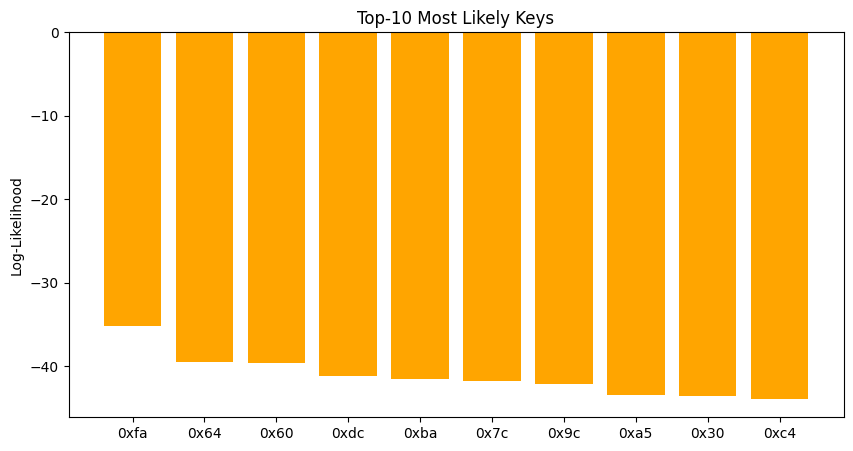


Top 5 most likely key bytes:
  Rank 1: 0xfa (Log-Likelihood: -35.19)
  Rank 2: 0x64 (Log-Likelihood: -39.51)
  Rank 3: 0x60 (Log-Likelihood: -39.65)
  Rank 4: 0xdc (Log-Likelihood: -41.21)
  Rank 5: 0xba (Log-Likelihood: -41.52)


In [3]:
# Colab-ready SCA training + attack script with plots
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
import math
import matplotlib.pyplot as plt

# --- CONFIG ---
DRIVE_BASE = "/content/drive/MyDrive"
DATASET_B_DIR = os.path.join(DRIVE_BASE, "datasetB")
DATASET_A_DIR = os.path.join(DRIVE_BASE, "datasetA")
MODEL_SAVE_PATH = os.path.join(DRIVE_BASE, "trained_sca_model.h5")
MOUNT_DRIVE = True

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# AES S-box and Hamming weight
sbox = (
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
)
hw = [bin(x).count("1") for x in range(256)]

def create_nn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Mount Drive if needed
if MOUNT_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

def load_npy(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    return np.load(path)

# --- STEP 1: Training ---
print("--- Training (Dataset B) ---")
prof_traces = load_npy(os.path.join(DATASET_B_DIR, "trace.npy"))
prof_plaintexts = load_npy(os.path.join(DATASET_B_DIR, "plaintext.npy"))
prof_keys = load_npy(os.path.join(DATASET_B_DIR, "key.npy"))

labels = [hw[sbox[int(pt) ^ int(k)]] for pt, k in zip(prof_plaintexts, prof_keys)]
labels_categorical = to_categorical(labels, num_classes=9)

trace_len = prof_traces.shape[1]
model = create_nn_model(trace_len, 9)
history = model.fit(prof_traces, labels_categorical, epochs=20, batch_size=256, verbose=2)

model.save(MODEL_SAVE_PATH)
print(f"✅ Model saved to {MODEL_SAVE_PATH}")

# Plot training accuracy & loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training Accuracy'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss', color='red')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Loss'); plt.legend()
plt.show()

# --- STEP 2: Attack ---
print("\n--- Attack (Dataset A) ---")
attack_traces = load_npy(os.path.join(DATASET_A_DIR, "trace.npy"))
attack_plaintexts = load_npy(os.path.join(DATASET_A_DIR, "plaintext.npy"))

predicted_probabilities = model.predict(attack_traces, batch_size=256, verbose=0)

log_likelihoods = np.zeros(256)
for k_guess in range(256):
    ll = 0
    for pt, probs in zip(attack_plaintexts, predicted_probabilities):
        sbox_out = sbox[int(pt) ^ k_guess]
        ll += math.log(probs[hw[sbox_out]] + 1e-30)
    log_likelihoods[k_guess] = ll

ranked_keys = np.argsort(log_likelihoods)[::-1]

# Plot log-likelihood distribution
plt.figure(figsize=(12,6))
plt.bar(range(256), log_likelihoods, color='skyblue')
plt.title("Log-Likelihood Scores for All 256 Key Guesses")
plt.xlabel("Key Guess (0-255)"); plt.ylabel("Log-Likelihood")
plt.show()

# Plot Top-10 keys
top_n = 10
plt.figure(figsize=(10,5))
top_keys = ranked_keys[:top_n]
plt.bar([f"0x{k:02x}" for k in top_keys], log_likelihoods[top_keys], color='orange')
plt.title("Top-10 Most Likely Keys")
plt.ylabel("Log-Likelihood")
plt.show()

print("\nTop 5 most likely key bytes:")
for i in range(5):
    k = ranked_keys[i]
    print(f"  Rank {i+1}: 0x{k:02x} (Log-Likelihood: {log_likelihoods[k]:.2f})")
